# Time Series

## Important Characteristics to Consider First

### Some important questions to first consider when first looking at a time series are:

    Is there a trend, meaning that, on average, the measurements tend to increase (or decrease) over time?
    Is there seasonality, meaning that there is a regularly repeating pattern of highs and lows related to calendar time such as seasons, quarters, months, days of the week, and so on?
    Are there outliers? In regression, outliers are far away from your line. With time series data, your outliers are far away from your other data.
    Is there a long-run cycle or period unrelated to seasonality factors?
    Is there constant variance over time, or is the variance non-constant?
    Are there any abrupt changes to either the level of the series or the variance?


# Necessary imports.

In [61]:
#import pandas_datareader
#from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import pylab as py

from warnings import filterwarnings
filterwarnings(action = "ignore")

## Styles for plots.

In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

# Import the data.


In [3]:
df_vac = pd.read_csv('https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-3.x/master/Section%202/vacation.csv', skiprows = 2)
df_vac.shape

(190, 2)

In [4]:
df_vac.head()

,Month,vacation: (United States)
0,2004-01,94
1,2004-02,89
2,2004-03,86
3,2004-04,79
4,2004-05,89


# Clean data.

## Renaming columns.

In [5]:
df_vac.columns = ['month', 'num_search']

## Missing data.

In [6]:
df_vac.isnull().sum()

month         0
num_search    0
dtype: int64

## To datetime index.

In [7]:
df_vac['month'] = pd.to_datetime(df_vac['month'])

# Set month as index column.
df_vac.set_index('month', inplace = True)

df_vac.sample(10)

,num_search
month,
2013-12-01,50
2008-06-01,83
2011-10-01,39
2011-11-01,40
2006-04-01,74
2011-12-01,50
2015-07-01,75
2005-10-01,54
2019-07-01,56


# Statistics.

## General desc.

In [8]:
df_vac.describe().round(2)

,num_search
count,190.00
mean,60.22
std,15.51
min,35.00
25%,50.00
50%,56.00
75%,70.00
max,100.00


## Skewness.
- Slightly skewed to the right.

In [9]:
df_vac['num_search'].skew()

0.5326528960073493

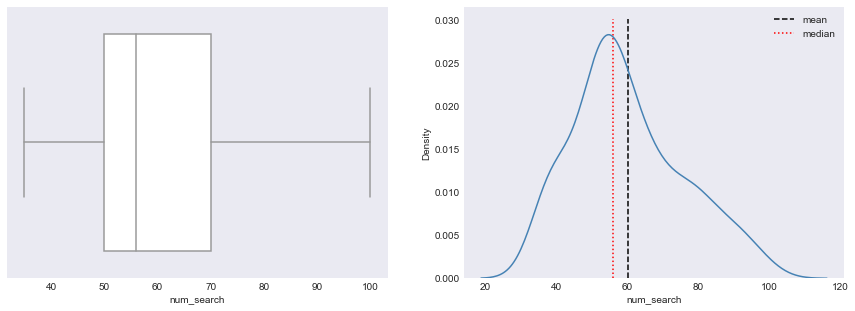

In [10]:
plt.style.use('seaborn-dark')
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(df_vac.num_search, color = 'white')

plt.subplot(1,2,2)
sns.kdeplot(df_vac.num_search, color = 'steelblue')
plt.vlines(df_vac.mean(), 0.0, 0.030, color = 'black', linestyle = 'dashed', label = 'mean')
plt.vlines(df_vac.median(), 0.0, 0.030, color = 'red', linestyle = 'dotted', label = 'median')

plt.legend()
plt.show()

# Plot.

<Figure size 1080x576 with 0 Axes>

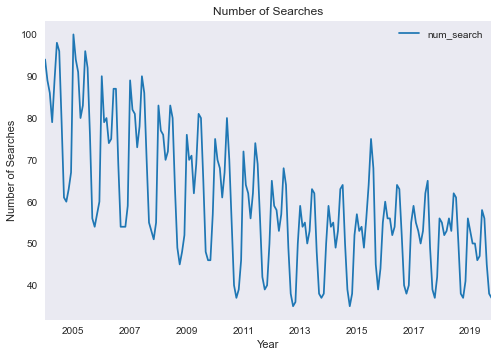

In [11]:
plt.style.use('seaborn-notebook')

plt.figure(figsize = (15,8))

ax = df_vac.plot(title = 'Number of Searches')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Searches")

plt.show()

# Fitting a Linear Regression line.

In [57]:
# Defining X and Y variables.

#x = np.arange(len(df_vac), dtype = np.float).reshape(-1, 1)
x = df_vac.index.values.reshape(-1, 1)
y = df_vac['num_search'].values.reshape(-1, 1)

# Train the model.
lin_model = LinearRegression()
lin_model.fit(x, y)

# Predictions and residuals.
predictions = lin_model.predict(df_vac['num_search'].values.astype(float).reshape(-1, 1))
residuals = y - predictions 


## Are the residuals normally distributed?

### Histograms

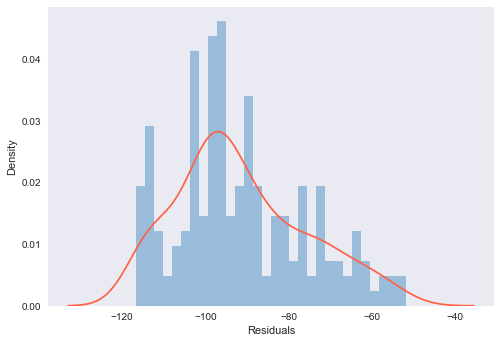

In [58]:
sns.distplot(residuals.ravel(), bins = 30, kde_kws = {'color' : "tomato", "alpha": 0.6})
plt.xlabel('Residuals')
plt.show()

### QQ-plot

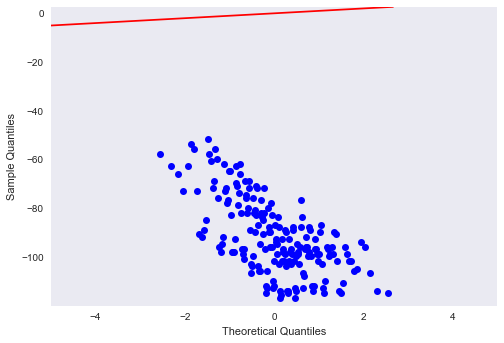

In [59]:
sm.qqplot(residuals, line ='45')
plt.xlim(-5, 5)
plt.show()

# Scatterplot of residuals

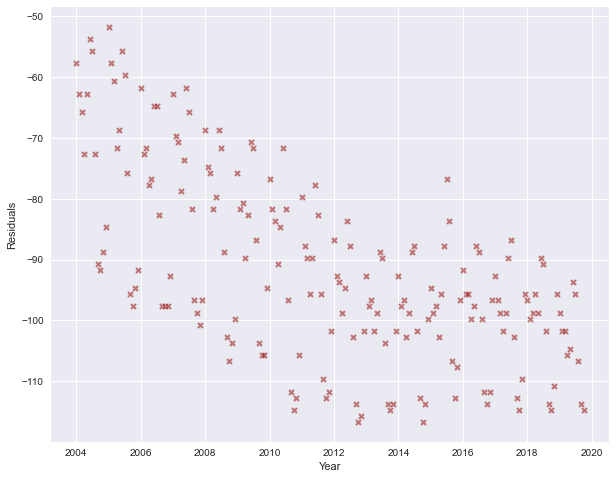

In [60]:
plt.figure(figsize = (10,8))
sns.scatterplot(y = residuals.ravel(), x = df_vac.index, color = 'darkred', alpha = 0.50, marker= 'X')
plt.xlabel("Year")
plt.ylabel("Residuals")
plt.grid()

# Time Series : Basics

## Autocorrelation

#### Autocorrelation is a useful tool in identifying statistically significant relationships among observed values in linear data. 

<p>
    This lets us know that previous data points influence the current price. 

    The strength of this relationship is measured on a scale of -1 to 1 when -1 being a 100% negative correlation and with a value of 1 being a 100% positive correlation. This measure is shown on the y-axis.

    Any value falling inside the blue shaded region has no significant correlation (alpha = 0.05).
</p>

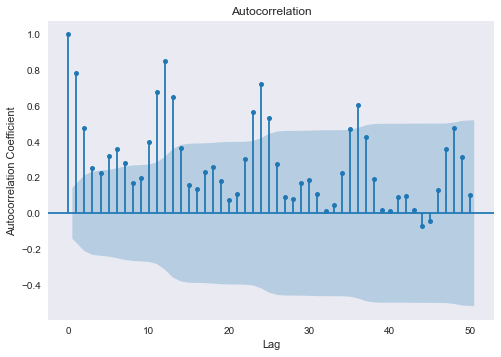

In [64]:
plot_acf(df_vac, lags = 50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficient')
plt.show()

## Random Walk

The Data point for the t-th time step is given by: <br>
`x[t] = x[t - 1] + z[t]`

Where,
z[t] --> White noise; May be Gaussian Noise.


### Generate random walk data.

In [78]:
# Mean and standard deviation of a standard normal distribution.
mu, sigma = 0, 1.0
random_walk = np.empty(1000)
random_walk[0] = 0.0

for ii in range(1, len(random_walk)):
    white_noise = np.random.normal(mu, sigma)    # Generates random noise from the std. normal distribution.
    random_walk[ii] = random_walk[ii-1] + white_noise

### Plot random walk time series.

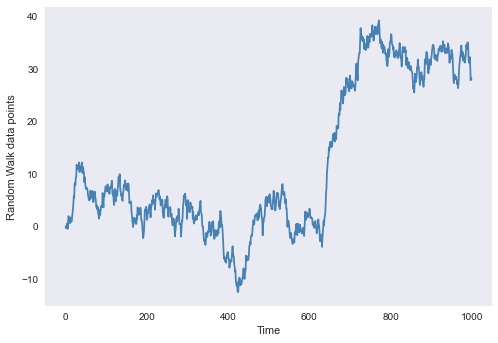

In [79]:
# Plot a time series of the random walk.
plt.plot(range(len(random_walk)), random_walk, color = 'steelblue')
plt.xlabel("Time")
plt.ylabel("Random Walk data points")
plt.show()

### Noise

`z[t] = x[t] - x[t - 1]`

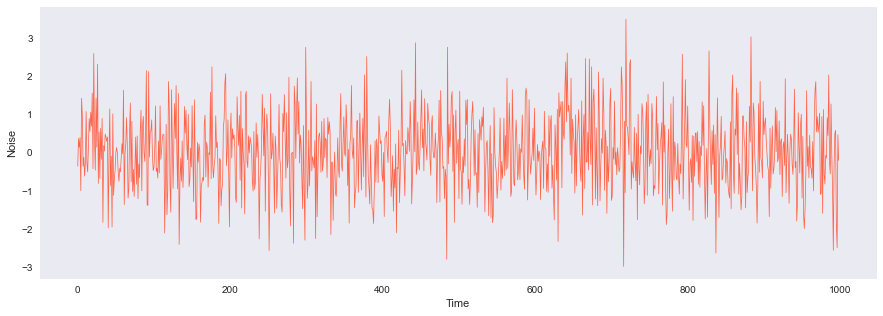

In [83]:
noise = random_walk[1:] - random_walk[:-1]

# Plot a time series of the noise of the underlying random walk.
plt.figure(figsize = (15,5))
plt.plot(range(len(noise)), noise, color = 'tomato', linewidth = 0.75)
plt.xlabel("Time")
plt.ylabel("Noise")
plt.show()

## Moving Average

Stock price x[t] is the linear combination of the noise from two days before. <br>
`x[t] = z[t] + theta[1] * z[t-1] + theta[2] * z[t-2]`

z[i] are iid r.v from N(mu, sigma).

### Generate moving average process.

In [90]:
noise = pd.Series(np.random.normal(mu, sigma, 10000))
weights = (1.0, 0.7, 0.3)
window_size = 3

# Applying moving weighted average operation.
ma_3 = noise.rolling(window_size).apply(lambda tt: (tt * weights).sum())
ma_3 = ma_3[2:].values

### Plot the moving average process.

Moving Average of window 'q' cuts off in correllogram at point 'q' in the x-axis.

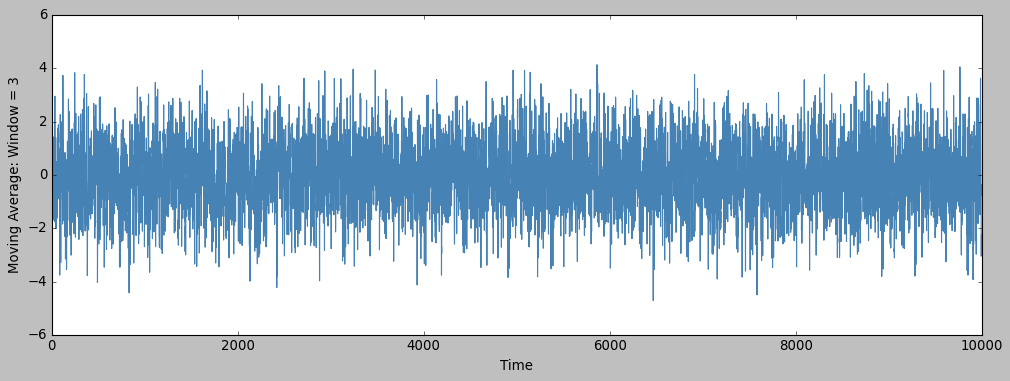

<Figure size 1200x400 with 0 Axes>

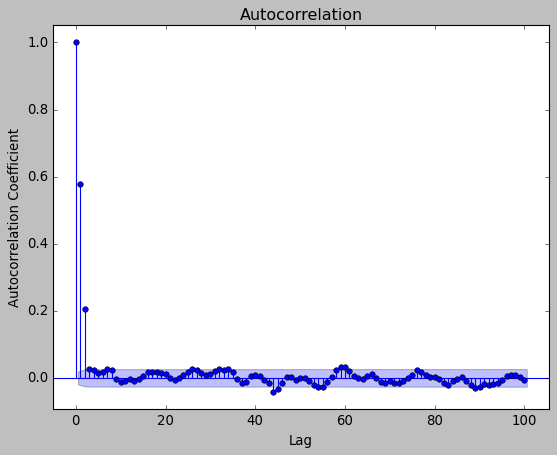

In [97]:
plt.figure(figsize = (15, 5))
plt.style.use('classic')

plt.plot(range(len(ma_3)), ma_3, color = 'steelblue')
plt.xlabel('Time')
plt.ylabel(f'Moving Average: Window = {window_size}')

plt.figure(figsize = (15, 5))
plot_acf(ma_3, lags = 100, alpha = 0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficient')

plt.show()

## Stochastic Process
<hr>

### Strictly stationary
More formally, we say a stochastic process is <b>strictly stationary</b> if <br>

`Joint Dist (x[t1], x[t2], ..., x[tk]) is same as Joint Dist (x[t1 + τ], x[t2 + τ], ..., x[tk + τ])`

<br>
It essentially says that the joint distribution doesn’t really depend upon where you are 
looking along the stochastic process. 

### Weakly stationary

We say a process i sweakly stationary if: <br>
- <b>Mean Function</b>: `μ(t) = μ   i.e constant`

- <b>ACF</b>: `γ(t1, t2) = γ(t1 - t2) = γ(τ)` ; where, 'τ' is some offset.



## White Noise: Stationary

`x[t] ~ iid N(0, σ^2)`

Mean Function: `μ(t) = 0   i.e constant`
<br>
Also, ACF: `γ(t1, t2) = 0 if t1 != t2 else σ^2`

## Random Walk: NOT Stationary

Start with `z[t] ~ iid(μ, σ^2)`
<br>
Build a walk with <i>t</i> steps:
<br>
`x[1] = z[1]` <br>
`x[2] = x[1] + z[2] = z[1] + z[2]`<br>
`x[3] = x[2] + z[3] = z[1] + z[2] + z[3]` <br>
and so on...<br>
`x[t] = z[1] + ... + z[t]`

<br>
Thus
<br>
    - E[x_t] = μ + μ + ... + μ = t.μ <br>
    - V[x_t] = σ^2 + σ^2 + ... + σ^2 = t.σ^2 <br>

=> Mean  and variance grows with time (t).

## Moving Average Processes are (weakly) stationary.


## Components of a Time Series

A time series is composed of mainly trend, seasonality, and noise.

## Trend

When we talk about trend, we are talking about how the series data increases or decreases over time. Is it moving higher or lower over the time frame? The series is either uptrend or downtrend, both of which are non-stationary.
## Seasonality

Seasonality refers to a repeating periodic or cyclical pattern with regular intervals within a series. The pattern is within a fixed time period and it repeats itself at regular intervals. There can be upward or downward swings but it continues to repeat over a fixed period of time as in a cycle. Cyclicality could repeat but it has no fixed period.
## Noise

In general, noise captures the irregularities or random variation in the series. It can have erratic events or simply random variation. It has a short duration. It is hard to predict due to its erratic occurrence.


# Modelling Time Series


## Additive Model

An additive model is linear: <br>
`y(t) = Trend + Seasonality + Noise`

It is useful when the variations around the trend does not vary with the level of the time series. Components are added together.

## Multiplicative Model

A multiplicative model is non-linear: <br>
`y(t) = Trend * Seasonality * Noise`

A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time. It is useful when the trend is proportional to the level of the time series. Components are multiplied together.


# How to Choose Between Additive and Multiplicative Decompositions?

    The additive model is useful when the seasonal variation is relatively constant over time.
    The multiplicative model is useful when the seasonal variation increases over time.


### Additive Model

In [12]:
res = seasonal_decompose(df_vac['num_search'], model = 'additive', freq = 12)

In [13]:
res.trend.head(10)

month
2004-01-01          NaN
2004-02-01          NaN
2004-03-01          NaN
2004-04-01          NaN
2004-05-01          NaN
2004-06-01          NaN
2004-07-01    80.333333
2004-08-01    80.791667
2004-09-01    81.208333
2004-10-01    81.458333
Name: trend, dtype: float64

In [14]:
res.seasonal.head(10)

month
2004-01-01    10.648661
2004-02-01     5.320883
2004-03-01     5.079216
2004-04-01    -0.259673
2004-05-01     3.574851
2004-06-01    14.530208
2004-07-01    13.501438
2004-08-01    -0.609673
2004-09-01   -14.868006
2004-10-01   -17.076339
Name: seasonal, dtype: float64

In [15]:
res.resid.head(10)

month
2004-01-01         NaN
2004-02-01         NaN
2004-03-01         NaN
2004-04-01         NaN
2004-05-01         NaN
2004-06-01         NaN
2004-07-01    2.165228
2004-08-01   -1.181994
2004-09-01   -5.340327
2004-10-01   -4.381994
Name: resid, dtype: float64

In [16]:
res.observed.head(10)

month
2004-01-01    94.0
2004-02-01    89.0
2004-03-01    86.0
2004-04-01    79.0
2004-05-01    89.0
2004-06-01    98.0
2004-07-01    96.0
2004-08-01    79.0
2004-09-01    61.0
2004-10-01    60.0
Name: num_search, dtype: float64

#### Plot the additive model.

<Figure size 576x1440 with 0 Axes>

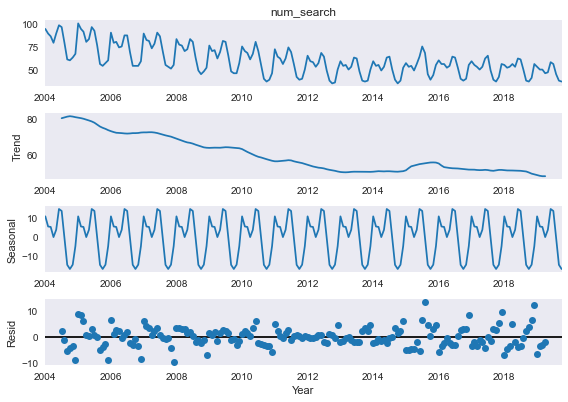

In [17]:
plt.figure(figsize = (8, 20))    
ax = res.plot()
plt.xlabel('Year')
plt.show()

### Multiplicative Model

In [18]:
res = seasonal_decompose(df_vac['num_search'], model = 'multiplicative', freq = 12)

In [19]:
res.trend.head(10)

month
2004-01-01          NaN
2004-02-01          NaN
2004-03-01          NaN
2004-04-01          NaN
2004-05-01          NaN
2004-06-01          NaN
2004-07-01    80.333333
2004-08-01    80.791667
2004-09-01    81.208333
2004-10-01    81.458333
Name: trend, dtype: float64

In [20]:
res.seasonal.head(10)

month
2004-01-01    1.172174
2004-02-01    1.083788
2004-03-01    1.081009
2004-04-01    0.993524
2004-05-01    1.058628
2004-06-01    1.243714
2004-07-01    1.224767
2004-08-01    0.990480
2004-09-01    0.753789
2004-10-01    0.714214
Name: seasonal, dtype: float64

In [21]:
res.resid.head(10)

month
2004-01-01         NaN
2004-02-01         NaN
2004-03-01         NaN
2004-04-01         NaN
2004-05-01         NaN
2004-06-01         NaN
2004-07-01    0.975713
2004-08-01    0.987222
2004-09-01    0.996506
2004-10-01    1.031305
Name: resid, dtype: float64

In [22]:
res.observed.head(10)

month
2004-01-01    94.0
2004-02-01    89.0
2004-03-01    86.0
2004-04-01    79.0
2004-05-01    89.0
2004-06-01    98.0
2004-07-01    96.0
2004-08-01    79.0
2004-09-01    61.0
2004-10-01    60.0
Name: num_search, dtype: float64

#### Plot the additive model.

<Figure size 576x1440 with 0 Axes>

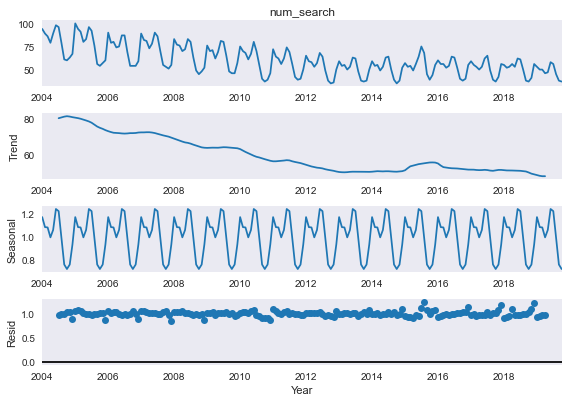

In [23]:
plt.figure(figsize = (8, 20))    
ax = res.plot()
plt.xlabel('Year')
plt.show()